In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import pickle
from keychest.keychestenv_gofa import features_for_obs
from copy import deepcopy
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import gin
from tqdm import tqdm
from functools import partial
from keychest.keychestenv import keychest_obs2d_to_image, keychest_obs3d_to_obs2d

In [2]:
# loading episodes
fn = 'episodes-1000-config-10x10.gin-105a835e-fc48-11ea-a584-7b4c3c93968e.pkl'
fn = 'keychest/' + fn
data = pickle.load(open(fn, 'rb'))

In [3]:
data[0][0]['observation'].shape

(21, 12, 10)

In [4]:
config_fn = fn.split('-')[3]
gin.enter_interactive_mode()
gin.parse_config_file(f"keychest/config/{config_fn}")

In [5]:
def one_hot_encode(value, entries):
    """Encode a value as 1-hot."""
    assert 0 <= value < entries
    result = np.zeros(entries, dtype=np.float32)
    result[value] = 1.0
    return result

In [6]:
ACTION_DIM = 4
one_hot_encode_action = partial(one_hot_encode, entries=ACTION_DIM)

In [7]:
# observation, action 1-hot
dataset_x = []

# reward, next observation, done
dataset_y = []

for episode in data:        
    prev_observation = episode[0]['observation']
    
    for i, step in enumerate(episode[1:]):
        dataset_y.append({})
        dataset_x.append({})
        
        dataset_x[-1]['action'] = one_hot_encode_action(step['action'])
        dataset_x[-1]['observation'] = prev_observation.transpose(2, 0, 1)
        dataset_y[-1]['observation'] = step['observation'].transpose(2, 0, 1)
        dataset_y[-1]['reward'] = step['reward']
        dataset_y[-1]['done'] = step['done']
        
        prev_observation = step['observation']
        
        
assert len(dataset_x) == len(dataset_y)

In [8]:
assert np.max(dataset_x[0]['observation']) == 1
assert dataset_x[0]['observation'].shape[0] == 10

In [9]:
dataset_x[0]['observation'].shape

(10, 21, 12)

In [10]:
device = torch.device("cuda")

In [11]:
device

device(type='cuda')

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(10, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(65, 16, (10, 6), stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 10, (3, 2), stride=2)
        
        # action encoder
        self.act_fc1 = torch.nn.Linear(4, 15)
        self.act_fc2 = torch.nn.Linear(15, 5)
        
        self.rew_fc1 = torch.nn.Linear(65, 15)
        self.rew_fc2 = torch.nn.Linear(15, 1)
        
        self.done_fc1 = torch.nn.Linear(65, 15)
        self.done_fc2 = torch.nn.Linear(15, 1)
        
        

    def encoder(self, x):
        code_obs = self.conv_encoder(x['observation'])
        code_action = self.action_encoder(x['action'])
        return torch.cat((code_obs, code_action), 1)
    
    def conv_encoder_noflat(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        return x
    
    def conv_encoder(self, x):
        x = self.conv_encoder_noflat(x)
        x = torch.flatten(x, start_dim=1)
        return x
    
    def action_encoder(self, x):
        x = F.relu(self.act_fc1(x))
        x = F.relu(self.act_fc2(x))
        return x
        
    def decode_obs(self, x):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = x.view(x.size(0), x.size(1), 1, 1)
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        return x
        
    def decode_reward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.rew_fc1(x))
        x = self.rew_fc2(x)
        return x.view(x.size(0))
    
    def decode_done(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.done_fc1(x))
        x = self.done_fc2(x)
        return x.view(x.size(0))
        
    def forward(self, x):
        code = self.encoder(x)
        
        new_obs = self.decode_obs(code)
        reward = self.decode_reward(code)
        done = self.decode_done(code)
        result = {'observation': new_obs,
                  'reward': reward,
                  'done': done}
        return result

# initialize the NN
model = ConvAutoencoder()
print(model)


ConvAutoencoder(
  (conv1): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(65, 16, kernel_size=(10, 6), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 10, kernel_size=(3, 2), stride=(2, 2))
  (act_fc1): Linear(in_features=4, out_features=15, bias=True)
  (act_fc2): Linear(in_features=15, out_features=5, bias=True)
  (rew_fc1): Linear(in_features=65, out_features=15, bias=True)
  (rew_fc2): Linear(in_features=15, out_features=1, bias=True)
  (done_fc1): Linear(in_features=65, out_features=15, bias=True)
  (done_fc2): Linear(in_features=15, out_features=1, bias=True)
)


In [13]:
data = {x: torch.from_numpy(np.array([y])) for x, y in dataset_x[0].items()}

In [14]:
decoded = model(data)

/home/sergei/miniconda3/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
model = model.to(device)

In [16]:
assert decoded['reward'].shape == (1,)
assert decoded['done'].shape == (1,)

In [17]:
assert decoded['observation'].shape == data['observation'].shape

In [18]:
def dct_fcn(dct, fcn):
    return {x: fcn(y) for x, y in dct.items()}

def dct_np(dct):
    return dct_fcn(dct, partial(np.array, dtype=np.float32))

def dct_torch(dct):
    return dct_fcn(dct, lambda x: torch.from_numpy(x))

def lstdct2dctlst(lst):
    result = {}
    for item in lst:
        for key, value in item.items():
            if key not in result:
                result[key] = []
            result[key].append(value)
    return dct_np(result)

In [19]:
dataset_x_dct = dct_torch(lstdct2dctlst(dataset_x))
dataset_y_dct = dct_torch(lstdct2dctlst(dataset_y))

In [20]:
p = np.random.permutation(len(dataset_x_dct['observation']))
#return a[p], b[p]

In [21]:
dataset_x_dct_train = dct_fcn(dataset_x_dct, lambda x: x[p])
dataset_y_dct_train = dct_fcn(dataset_y_dct, lambda x: x[p])

In [22]:
dataset_x_dct['observation'].shape

torch.Size([22350, 10, 21, 12])

In [23]:
#model_pred = model(dataset_x_dct)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
loss_mse = nn.MSELoss()

In [60]:
def loss_rl_pred(data_pred, data_y):
    result = 0
    # keys = data_pred.keys()
    keys = ['observation']
    for key in keys:
        result += loss_mse(data_pred[key], data_y[key])
    return result

In [61]:
#del model
#torch.cuda.empty_cache()

In [62]:
epochs = 50
batch_size = 4096


for epoch in range(epochs):
    with tqdm(total=len(dataset_x_dct_train['observation']) // batch_size) as pbar:
        for i, batch in enumerate(range(0, len(dataset_x_dct_train['observation']), batch_size)):
            x = dct_fcn(dataset_x_dct_train, lambda x: x[batch : batch + batch_size].to(device))
            y = dct_fcn(dataset_y_dct_train, lambda x: x[batch : batch + batch_size].to(device))

            if not x['observation'].shape[0]: continue

            out = model(x)
            loss = loss_rl_pred(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            #to_print = "Epoch[{}/{}] Loss: {:.3f}".format(epoch + 1, epochs, loss.data)
            #print(to_print)
            pbar.set_postfix(loss=loss.data.cpu().numpy())
            pbar.update(1)

6it [00:00, 12.05it/s, loss=0.0075170957]                       
6it [00:00, 13.56it/s, loss=0.007513974]                        
6it [00:00, 13.64it/s, loss=0.0075109378]                       
6it [00:00, 13.82it/s, loss=0.007507676]                        
6it [00:00, 13.94it/s, loss=0.0075046485]                       
6it [00:00, 13.49it/s, loss=0.0075016]                          
6it [00:00, 13.50it/s, loss=0.0074985996]                       
6it [00:00, 13.35it/s, loss=0.007495701]                        
6it [00:00, 13.26it/s, loss=0.007492953]                        
6it [00:00, 13.65it/s, loss=0.007490234]                        
6it [00:00, 13.17it/s, loss=0.0074876356]                       
6it [00:00, 13.78it/s, loss=0.0074851406]                       
6it [00:00, 13.70it/s, loss=0.0074827317]                       
6it [00:00, 13.78it/s, loss=0.0074804123]                       
6it [00:00, 13.86it/s, loss=0.007478166]                        
6it [00:00, 13.60it/s, lo

In [63]:
batch = 0
x = dct_fcn(dataset_x_dct_train, lambda x: x[batch * batch_size : (batch + 1) * batch_size].to(device))

In [64]:
pred = model(x)['observation'][0].detach().cpu().numpy().transpose(1, 2, 0)

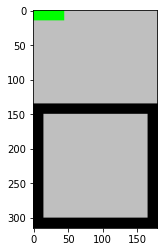

In [65]:
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(1 * (pred > 0.5))))

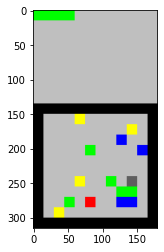

In [66]:
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(dataset_x_dct_train['observation'][0].numpy().transpose(1, 2, 0))))